# Single neuron TB

In [6]:
# % matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import importlib
import tensorflow as tf
from spiker import *
from IPython.display import clear_output, Image, display, HTML

# Test bench for Neuron
# Ip -> Neuron -> Syn -> Vsyn
if(1):
    Ts = 1e-6
    tstart = 0
    tstop = 0.3
    tseries = gen_time(tstart,tstop,Ts)
    ipt     = gen_sine(tseries,6)
    
    test0 = np.zeros_like(tseries.time)#.astype(np.bool_)
    test1 = np.zeros_like(tseries.time)#.astype(np.bool_)
    test2 = np.zeros_like(tseries.time)#.astype(np.bool_)
    test3 = np.zeros_like(tseries.time)#.astype(np.bool_)

    ipt.set_time(0.)
    n = Neuron(1,Ts=Ts)
    v = Vsyn(1,Ts=Ts)
    x = Vsyn(1,Ts=Ts)
    
    n1op = 0.0
    for index in range(len(tseries.time)):
        ip = ipt.value[index]
        xop = x.compute(ip)
        nop = n.compute(ip)
        vop = v.rd_upd(nop)
        v.compute(vop)
        test0[index] = n.irecon[0]
        #test0[index] = n.states[0]
        test1[index] = x.states[0]
        test2[index] = v.states[0]
    tx0 = Tseries(test0,tseries.time,Ts)    
    tx1 = Tseries(test1,tseries.time,Ts)
    tx2 = Tseries(test2,tseries.time,Ts)    

No handles with labels found to put in legend.


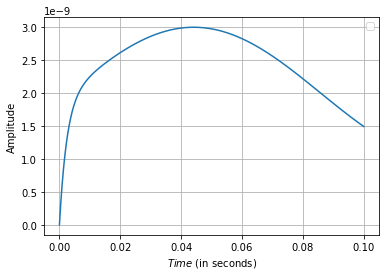

In [7]:
tx0.plot(0,0.1)

------------------

Neuron properties

Delta =  [1.e-10]
Step time =  1e-06
------------------

Input DPI properties

Step time =  1e-06
Time constant =  0.0024620943832914352
Gain =  1.0
------------------

Feedback DPI properties

Step time =  1e-06
Time constant =  0.001477256629974861
Gain =  100.0
b =  [2.70680555e-09]
------------------

Error DPI properties

Step time =  1e-06
Time constant =  73.86283149874305
Gain =  100.0
------------------

Number of spikes = 7.0

------------------



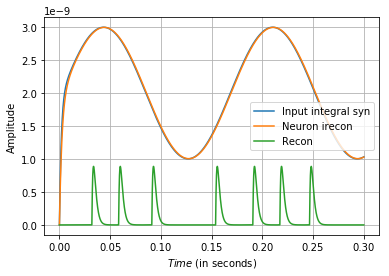

<Figure size 432x288 with 0 Axes>

In [8]:
    start= 0.0
    stop = None
    tx1.plot(start,stop,"Input integral syn")
    tx0.plot(start,stop,"Neuron irecon")
    tx2.plot(start,stop,"Recon")
    plt.figure()

    n.print_props()

In [11]:
# Building the graph here
# Create an empty graph
tbgraph = tf.Graph()

# Define graph structure
with tbgraph.as_default():
    # Result placeholder variables
    result0 = tf.Variable(tf.zeros(1), name="result0")
    result1 = tf.Variable(tf.zeros(1), name="result1")
    result2 = tf.Variable(tf.zeros(1), name="result2")
    
    # Input
    X = tf.placeholder(tf.float32,name="Input")
    Xip = tf.expand_dims(X, 0)
    
    InSyn = Syntf(Xip,1,Itau=30e-12,Ith=30e-12,name="InSyn") # Input synapse
    N = Neurontf(InSyn.states,1,name="Neuron") # Neuron
    OSyn = Syntf(N.frecon,1,Itau=30e-12,Ith=30e-12,name="OpSyn") # Output synapse
    
    irecon = tf.assign(result0,Xip)
    # Neuron update
    with tf.control_dependencies([InSyn.next_state]):
        nrecon = tf.assign(result1,InSyn.states)
        with tf.control_dependencies([N.next_state]):
            recon = tf.assign(result2,OSyn.next_state)
    initializer = tf.global_variables_initializer()

In [12]:
test_ip = ipt.value

# Result collection variable
res0 = np.zeros_like(test_ip)
res1 = np.zeros_like(test_ip)
res2 = np.zeros_like(test_ip)
    
# Create session
sess = tf.InteractiveSession(graph=tbgraph,config=tf.ConfigProto(log_device_placement=True))

# For generating inline graphs
writer = tf.summary.FileWriter("./graphs", sess.graph)
    
# Initialize graph
initializer.run()

# Step through time
for index in range(len(test_ip)):
    res0[index],res1[index],res2[index] = sess.run([irecon,nrecon,recon], feed_dict={X:test_ip[index]})
    #res0[index],res1[index] = sess.run([irecon,nrecon], feed_dict={X:test_ip[index]})
        
# Close graph drawing tool
writer.close()
    
# Show the computed graph
show_graph(tf.get_default_graph().as_graph_def())
    
# Close session
sess.close()

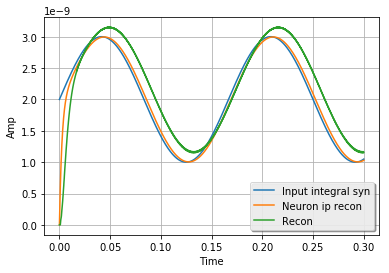

In [13]:
rs0 = Tseries(res0,tseries.time)
rs1 = Tseries(res1,tseries.time)
rs2 = Tseries(res2,tseries.time)
rs0.plot(label="Input integral syn")
rs1.plot(label="Neuron ip recon")
rs2.plot(label="Recon")

In [14]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]# if x.device_type == 'GPU']

get_available_gpus()

[u'/cpu:0']